In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cut_plot import histToPlot, basicHist, basicScatter

## Get data from file, apply cuts

In [5]:
data_dir = "G:/My Drive/crystalize/data/data-202104/041421/Po_2.8g_3.0c_1.1bar_circ_60min_1747/"

In [30]:
# set plotting style
mpl.rcParams['font.size']=10
mpl.rcParams['legend.fontsize']='small'
mpl.rcParams['figure.autolayout']=True
mpl.rcParams['figure.figsize']=[8.0,6.0]
mpl.rcParams['figure.max_open_warning']=False

# use for coloring pulses
pulse_class_colors = np.array(['blue', 'green', 'red', 'magenta', 'darkorange'])
pulse_class_labels = np.array(['Other', 'S1-like LXe', 'S1-like gas', 'S2-like', 'Merged S1/S2'])
pc_legend_handles=[]
for class_ind in range(len(pulse_class_labels)):
    pc_legend_handles.append(mpl.patches.Patch(color=pulse_class_colors[class_ind], label=str(class_ind)+": "+pulse_class_labels[class_ind]))


# ==================================================================
# define DAQ and other parameters
tscale = (8.0/4096.0)     # = 0.002 µs/sample, time scale

n_sipms = 8
n_channels = n_sipms+1 # includes sum

# define top, bottom channels
n_top = int((n_channels-1)/2)
top_channels=np.array(range(n_top),int)
bottom_channels=np.array(range(n_top,2*n_top),int)

#read RQ
listrq = np.load(data_dir+'rq.npz')

n_events = listrq['n_events'][()]
n_pulses = listrq['n_pulses']
n_s1 = listrq['n_s1']
n_s2 = listrq['n_s2']
s1_before_s2 = listrq['s1_before_s2']
p_area = listrq['p_area']
p_class = listrq['p_class']
drift_Time = listrq['drift_Time']
drift_Time_AS = listrq['drift_Time_AS']
p_max_height = listrq['p_max_height']
p_min_height = listrq['p_min_height']
p_width = listrq['p_width']
p_afs_2l = listrq['p_afs_2l']
p_afs_50 = listrq['p_afs_50']
p_area_ch = listrq['p_area_ch']
p_area_ch_frac = listrq['p_area_ch_frac']
p_area_top = listrq['p_area_top']
p_area_bottom = listrq['p_area_bottom']
p_tba = listrq['p_tba']
p_start = listrq['p_start']
p_end = listrq['p_end']
sum_s1_area = listrq['sum_s1_area']
sum_s2_area = listrq['sum_s2_area']

center_top_x = listrq['center_top_x']
center_top_y = listrq['center_top_y']
center_bot_x = listrq['center_bot_x']
center_bot_y = listrq['center_bot_y']

listrq.close()
#end of RQ read

n_golden = int(np.sum(drift_Time>0))
print("number of golden events found = {0:d} ({1:g}%)".format(n_golden,n_golden*100./n_events))

p_t_rise = tscale*(p_afs_50-p_afs_2l)

# Define some standard cuts for plotting
cut_dict = {}
cut_dict['ValidPulse'] = p_area > 0
cut_dict['PulseClass0'] = p_class == 0
cut_dict['S1'] = (p_class == 1) + (p_class == 2)
cut_dict['S2'] = (p_class == 3) + (p_class == 4)
cut_dict['Co_peak'] = (p_area>30)*(p_area<60)
cut_dict['PoS1'] = cut_dict['S1']*(p_tba<-0.2)*(p_tba>-1.01)*(p_area>2000)*(p_area<22000)
SS_cut = drift_Time > 0

# Pick which cut from cut_dict to apply here and whether to save plots
save_pulse_plots=True # One entry per pulse
save_S1S2_plots=True # One entry per S1 (S2) pulse
save_event_plots=True # One entry per event
save_2S2_plots=True # One entry per event w/ 2 S2s
save_PoS1_plots=False # One entry per event w/ 1 Po S1, specific to studies of S2 multiplicity
pulse_cut_name = 'PoS1'#'Co_peak'
pulse_cut = cut_dict[pulse_cut_name]
print("number of pulses found passing cut "+pulse_cut_name+" = {0:d} ({1:g}% of pulses found)".format(np.sum(pulse_cut),np.sum(pulse_cut)*100./np.sum(n_pulses)))
#pulse_cut_name = 'ValidPulse_SS_Evt'
#pulse_cut = pulse_cut*SS_cut[:,np.newaxis] # add second dimension to allow broadcasting

cleanArea = p_area[pulse_cut].flatten()
cleanMax = p_max_height[pulse_cut].flatten()
cleanMin = p_min_height[pulse_cut].flatten()
cleanWidth = p_width[pulse_cut].flatten()
cleanPulseClass = p_class[pulse_cut].flatten()

cleanAFS2l = p_afs_2l[pulse_cut].flatten()
cleanAFS50 = p_afs_50[pulse_cut].flatten()
cleanRiseTime = p_t_rise[pulse_cut].flatten()

cleanAreaCh = p_area_ch[pulse_cut] # pulse_cut gets broadcast to the right shape
cleanAreaChFrac = p_area_ch_frac[pulse_cut]
cleanAreaTop = p_area_top[pulse_cut].flatten()
cleanAreaBottom = p_area_bottom[pulse_cut].flatten()
cleanTBA = p_tba[pulse_cut].flatten()
# Note: TBA can be <-1 or >+1 if one of top or bottom areas is <0 (can still be a valid pulse since total area >0)

s1_cut = pulse_cut*cut_dict['S1']
cleanS1Area = p_area[s1_cut].flatten()
cleanS1RiseTime = p_t_rise[s1_cut].flatten()
cleanS1AreaChFrac = p_area_ch_frac[s1_cut]
cleanS1TBA = p_tba[s1_cut].flatten()
print("number of S1 pulses found = {0:d} ({1:g}% of pulses found)".format(np.sum(s1_cut),np.sum(s1_cut)*100./np.sum(n_pulses)))

s2_cut = pulse_cut*cut_dict['S2']
cleanS2Area = p_area[s2_cut].flatten()
cleanS2RiseTime = p_t_rise[s2_cut].flatten()
cleanS2AreaChFrac = p_area_ch_frac[s2_cut]
cleanS2TBA = p_tba[s2_cut].flatten()
print("number of S2 pulses found = {0:d} ({1:g}% of pulses found)".format(np.sum(s2_cut),np.sum(s2_cut)*100./np.sum(n_pulses)))


# Event level quantities
event_cut_dict = {}
event_cut_dict["SS"] = drift_Time > 0
event_cut_dict["All_Scatter"] = drift_Time_AS > 0
event_cut_dict["MS"] = (n_s1 == 1)*(n_s2 > 1)*s1_before_s2
event_cut_dict["Po"] = (drift_Time>4)*np.any((p_tba<-0.0)*(p_tba>-0.7)*(p_area>1000)*(p_area<4000), axis=1)#np.any((p_tba<-0.85)*(p_tba>-0.91)*(p_area>1500)*(p_area<2700), axis=1) # true if any pulse in event matches these criteria
event_cut_dict["Po_AS"] = (drift_Time_AS>0.)*(drift_Time_AS<1.5)*np.any((p_tba<-0.6)*(p_tba>-1)*(p_area>5000)*(p_area<20000), axis=1)#np.any((p_tba<-0.85)*(p_tba>-0.91)*(p_area>1500)*(p_area<2700), axis=1) # true if any pulse in event matches these criteria
event_cut_dict["lg_S1"] = (drift_Time>0)*np.any((p_area>1000.)*cut_dict["S1"], axis=1) # true if any S1 has area>1000
event_cut_dict["2S2"] = (n_s2 == 2)
event_cut_dict["PoS1"] = (np.sum(cut_dict['PoS1'], axis=1)==1)#*(n_s2>0)

event_cut_name = "SS"#"Po"#"lg_S1"
event_cut = event_cut_dict[event_cut_name]
cleanSumS1 = sum_s1_area[event_cut]
cleanSumS2 = sum_s2_area[event_cut]
# For events passing event_cut, get area-weighted avg of TBA for S1s only
cleanAvgS1TBA = np.sum(p_area[event_cut]*p_tba[event_cut]*s1_cut[event_cut],axis=1)/np.sum(p_area[event_cut]*s1_cut[event_cut],axis=1)
cleanDT = drift_Time[event_cut]
cleanDT_AS = drift_Time_AS[event_cut]
print("number of events found passing cut "+event_cut_name+" = {0:d} ({1:g}%)".format(np.sum(event_cut),np.sum(event_cut)*100./n_events))

number of golden events found = 13393 (9.8783%)
number of pulses found passing cut PoS1 = 20527 (11.4304% of pulses found)
number of S1 pulses found = 20527 (11.4304% of pulses found)
number of S2 pulses found = 0 (0% of pulses found)
number of events found passing cut SS = 13393 (9.8783%)


C:\Users\swkra\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in true_divide


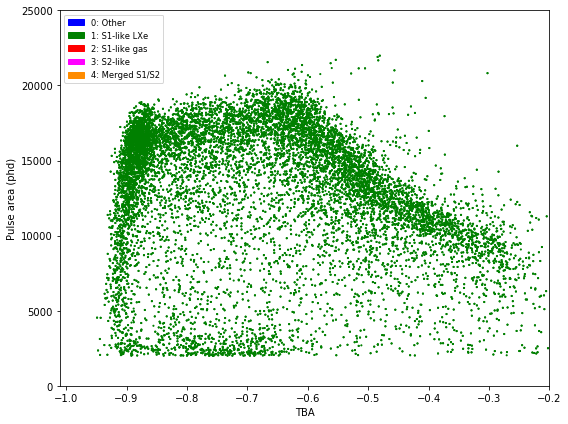

In [31]:
basicScatter(cleanTBA, cleanArea, s=1.2, c=pulse_class_colors[cleanPulseClass], xlim=[-1.01,-0.2], ylim=[0, 25000], xlabel="TBA", ylabel="Pulse area (phd)", legHand=pc_legend_handles, name="PulseArea_vs_TBA_"+pulse_cut_name, save=False, data_dir=data_dir, show=True)

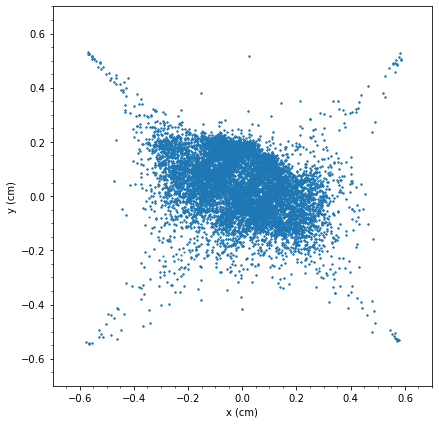

In [56]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

d_between_SiPM_center_x = 1.23
d_between_SiPM_center_y = 1.14
TPC_diameter = 3.0 # in cm
clean_center_bot_x_d = center_bot_x[pulse_cut] * d_between_SiPM_center_x/2
clean_center_bot_y_d = center_bot_y[pulse_cut] * d_between_SiPM_center_y/2
clean_center_top_x_d = center_top_x[pulse_cut] * d_between_SiPM_center_x/2
clean_center_top_y_d = center_top_y[pulse_cut] * d_between_SiPM_center_y/2
circ = plt.Circle((0,0), radius=TPC_diameter/2, color='g', fill = False)
plt.scatter(clean_center_bot_x_d, clean_center_bot_y_d, s = 1.2)
plt.xlim(-0.7,0.7)
plt.ylim(-0.7,0.7)
plt.ylabel("y (cm)")
plt.xlabel("x (cm)")
plt.minorticks_on()
ax.add_patch(circ)
ax.set_aspect('equal', adjustable='box')
# ax.annotate('TPC', xy =(TPC_diameter/2*np.cos(np.pi*37/180), TPC_diameter/2*np.sin(np.pi*37/180)),
#                 xytext =(1.4, 1.2), 
#                 arrowprops = dict(facecolor ='green',
#                                   shrink = 0.05))

## Make plots for different slices in TBA

In [ ]:
TBA_down = np.linspace(-0.95, -0.8, 10)
TBA_up = np.linspace(-0.8, -0.2, 6)
TBA_bins = np.concat

basicScatter(cleanTBA, cleanArea, s=1.2, c=pulse_class_colors[cleanPulseClass], xlim=[-1.01,-0.2], ylim=[0, 25000], xlabel="TBA", ylabel="Pulse area (phd)", legHand=pc_legend_handles, name="PulseArea_vs_TBA_"+pulse_cut_name, save=False, data_dir=data_dir, show=True)

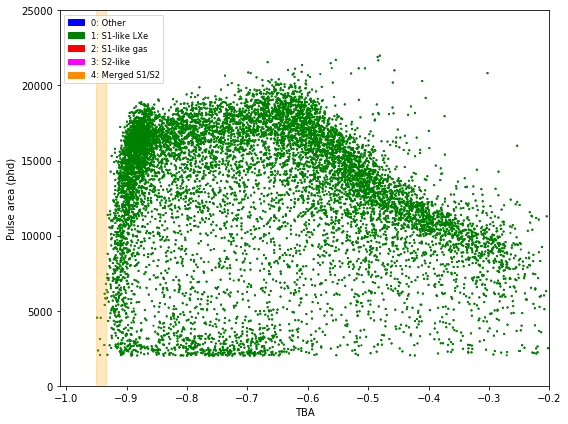

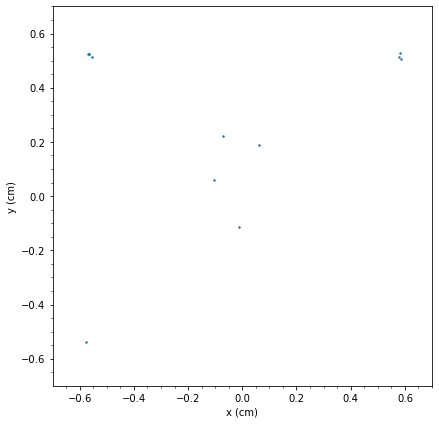

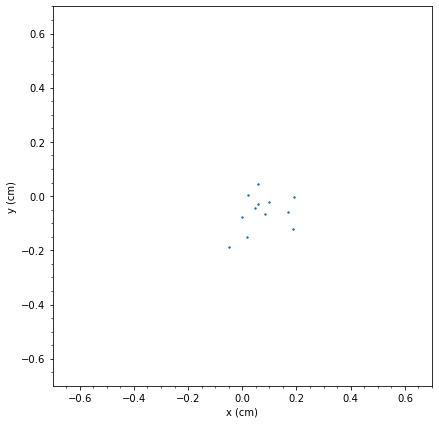

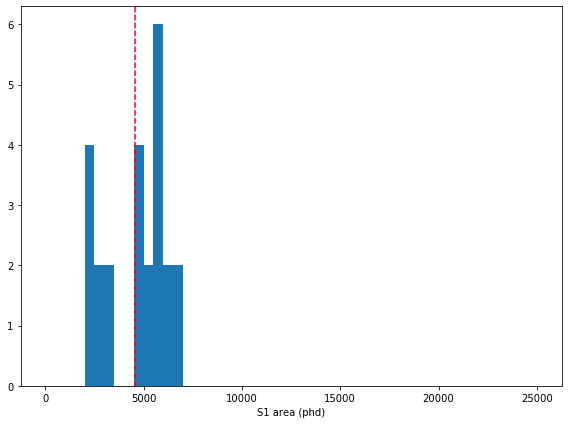

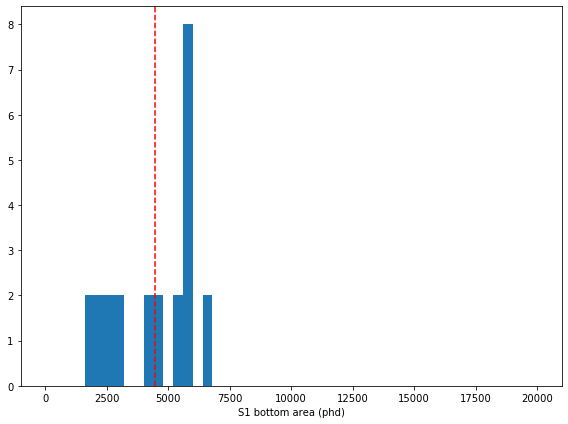

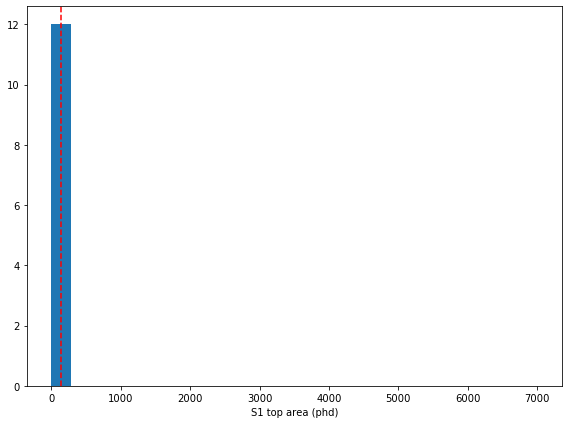

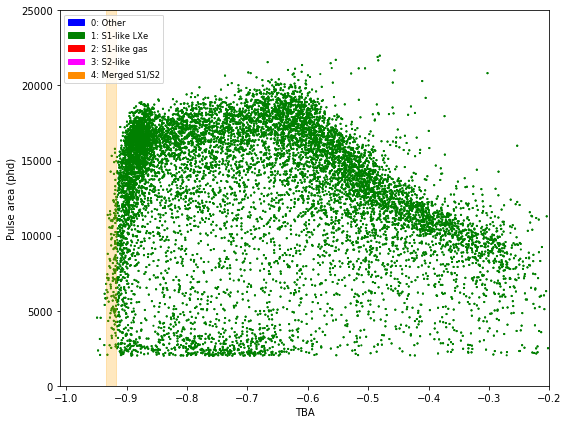

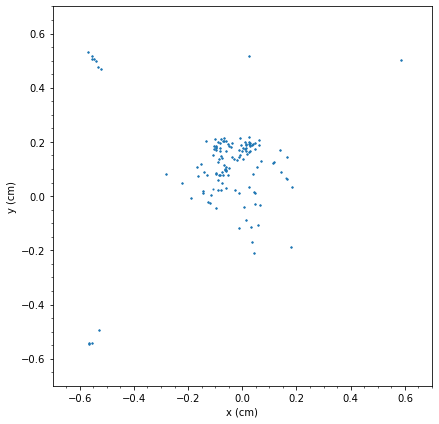

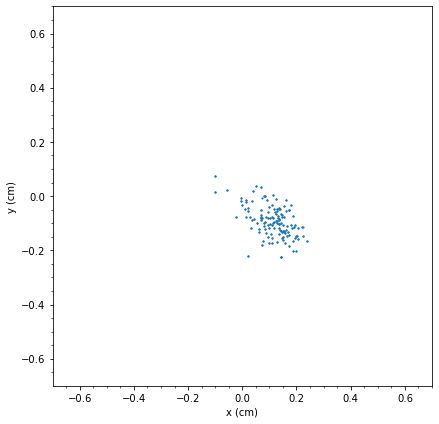

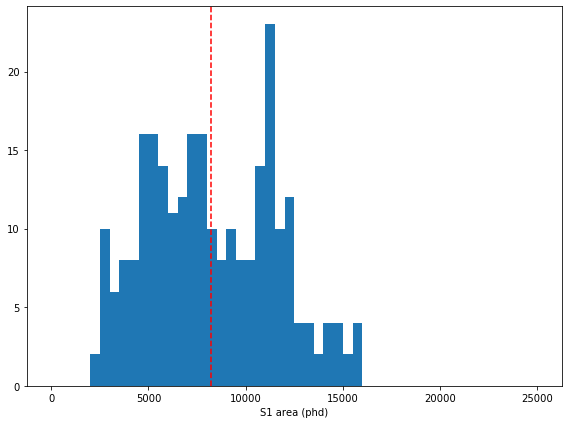

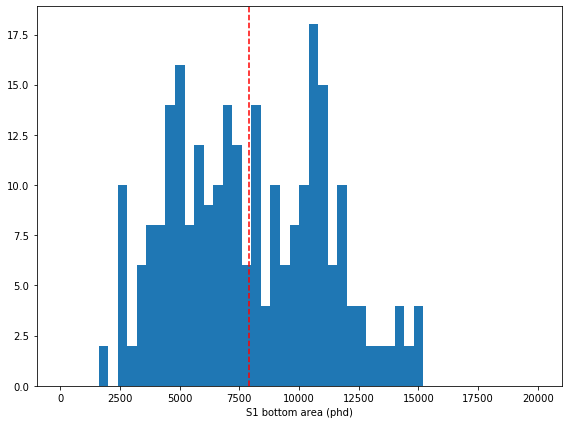

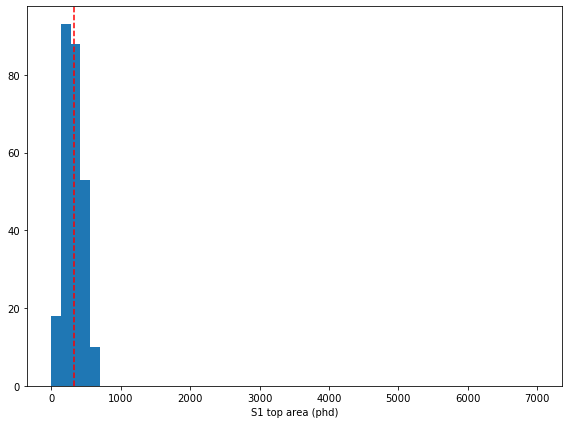

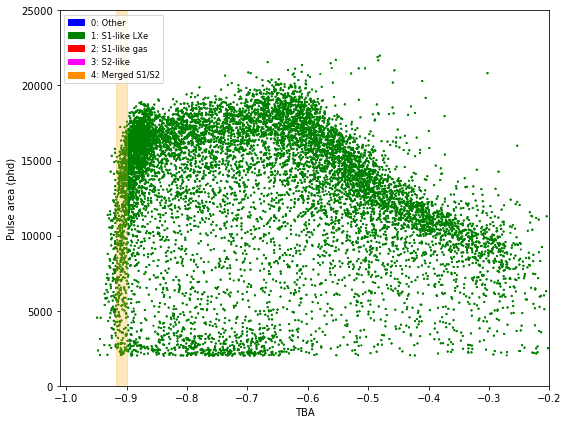

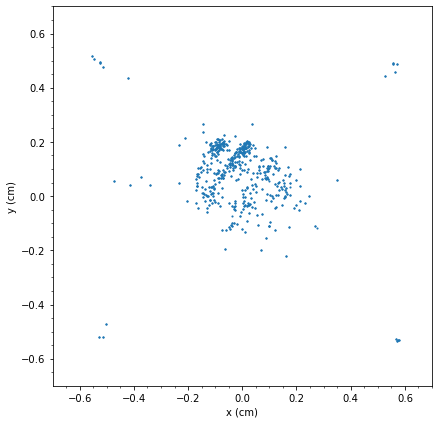

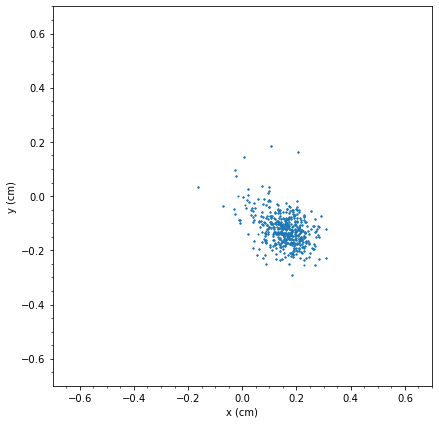

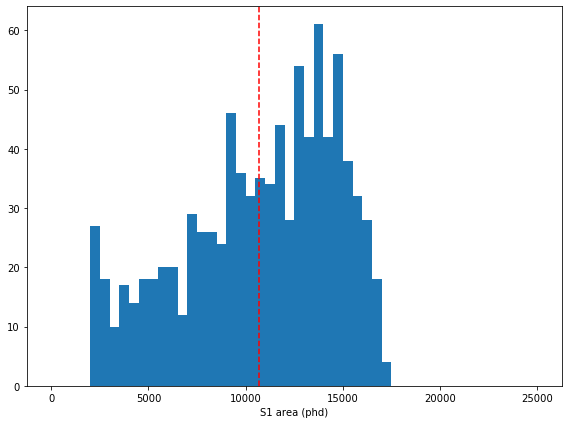

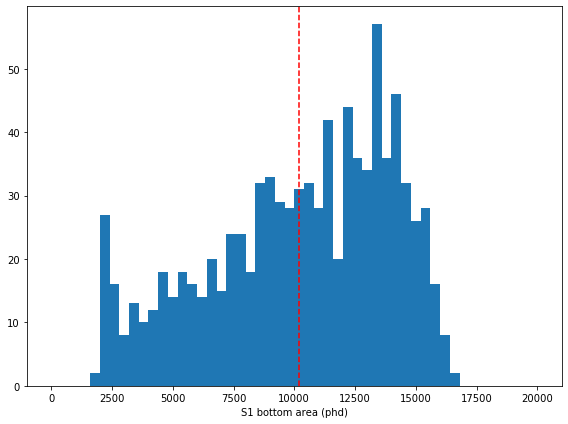

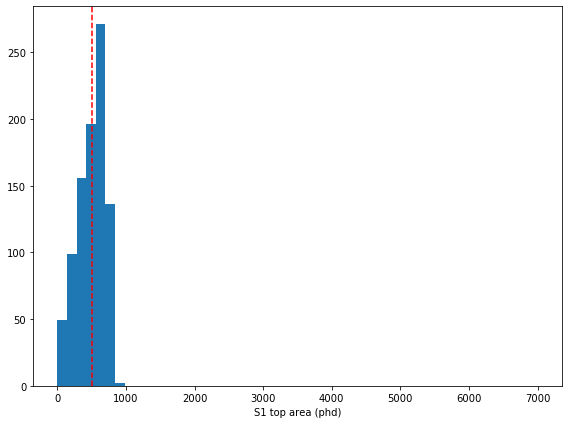

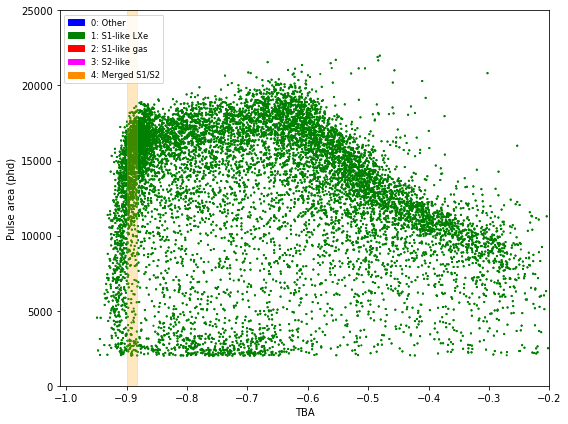

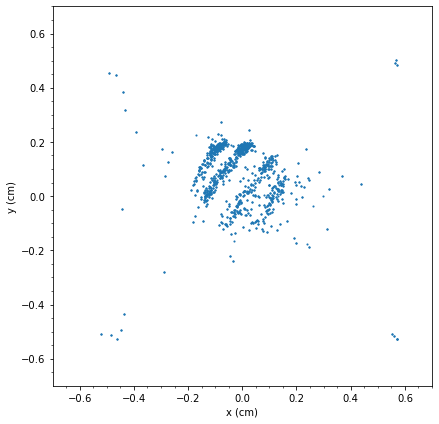

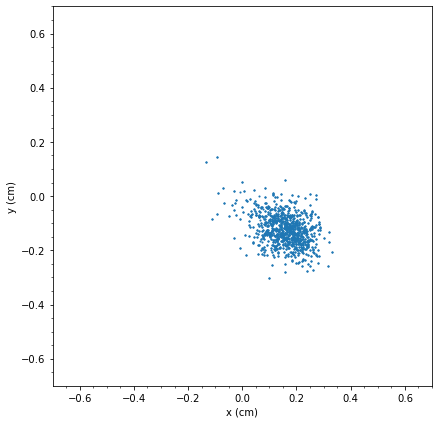

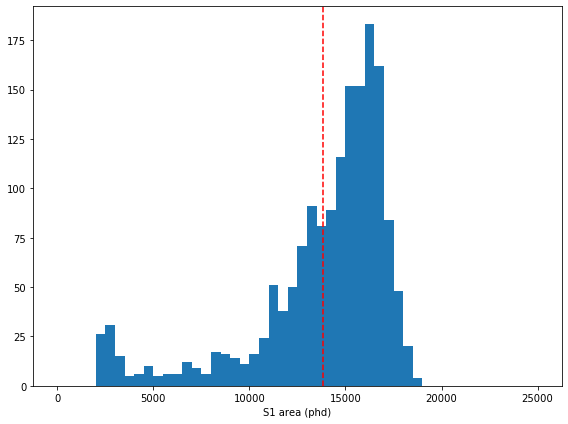

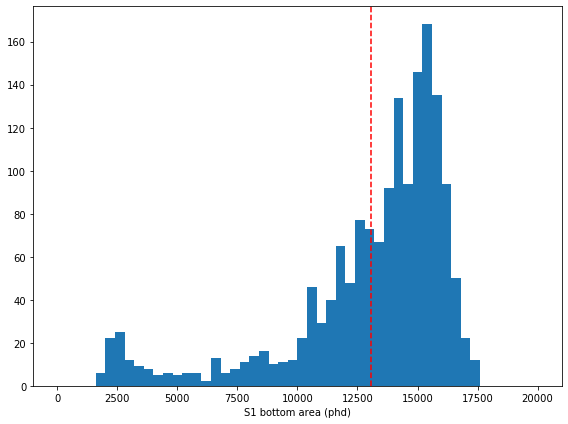

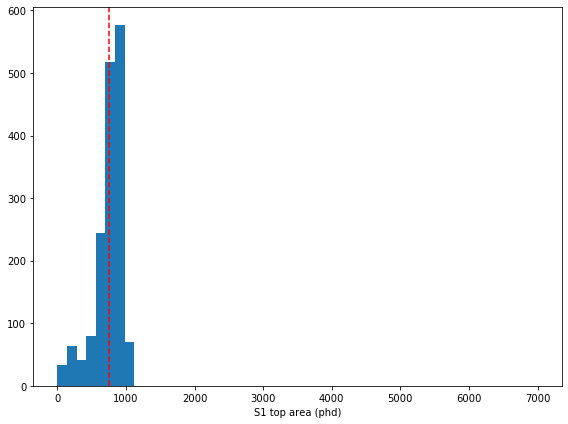

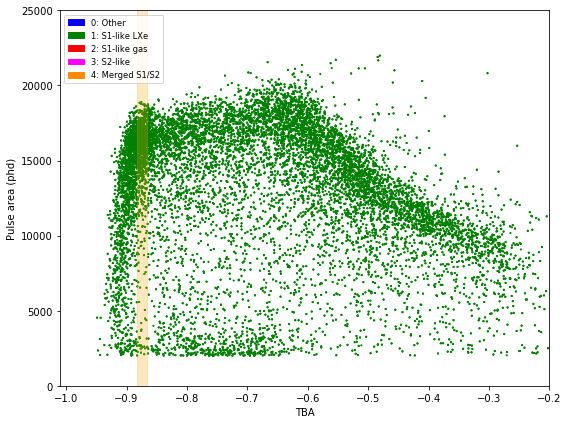

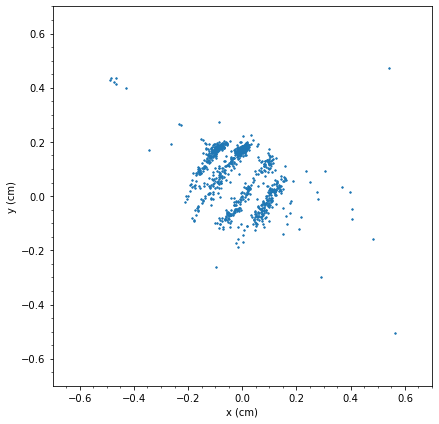

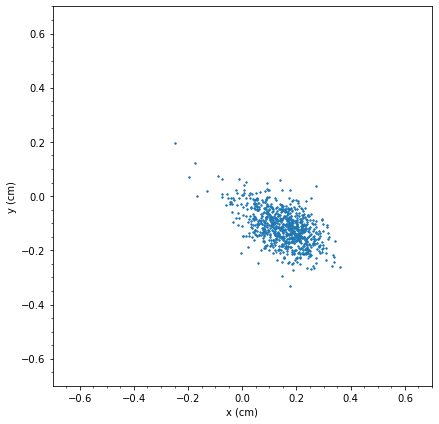

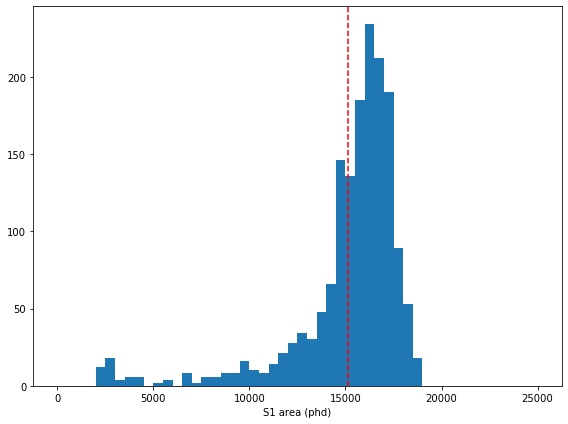

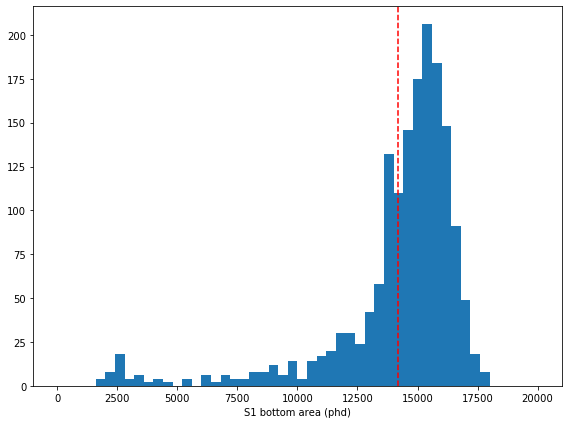

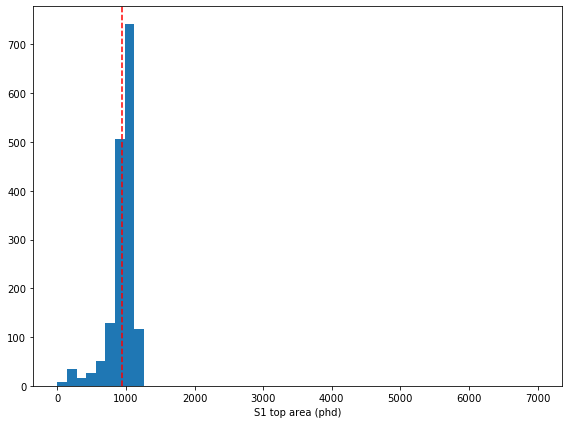

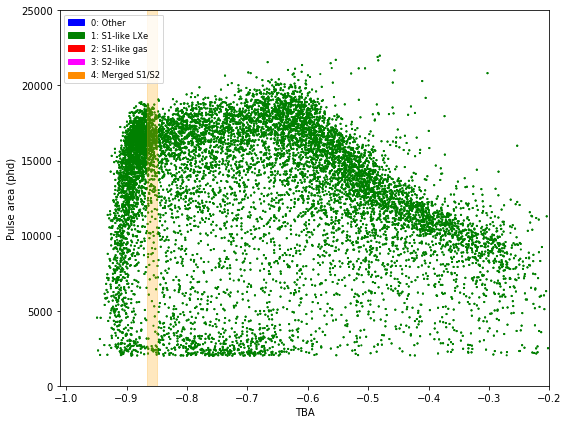

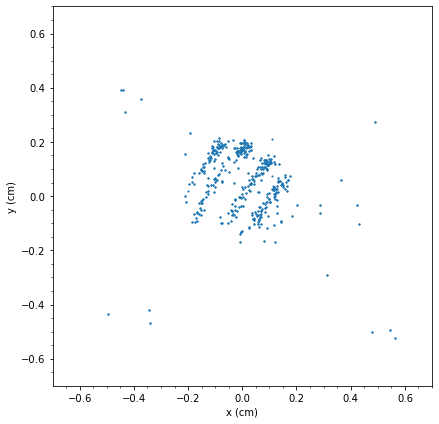

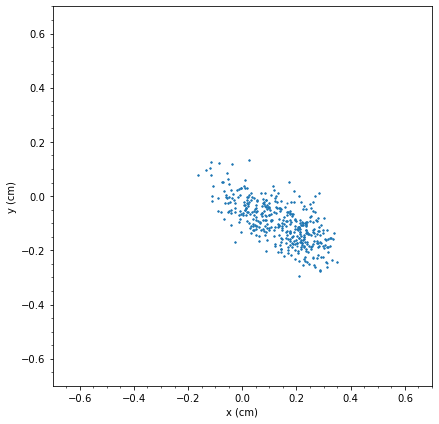

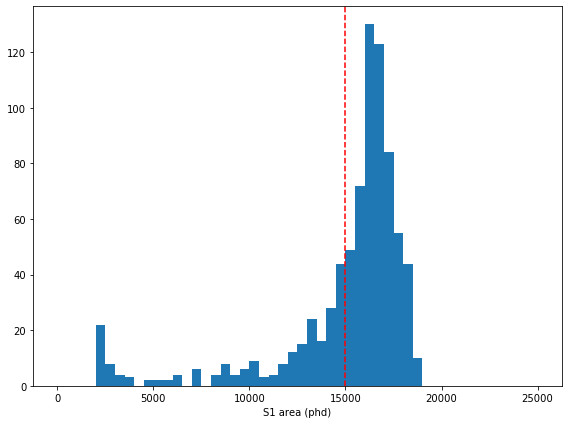

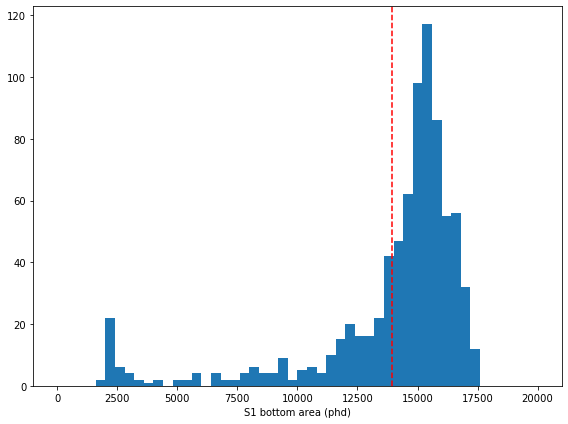

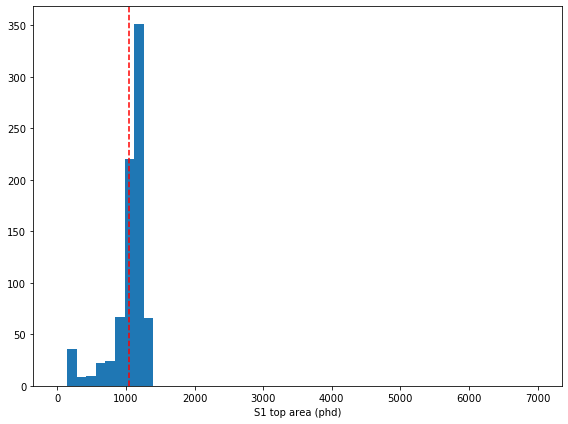

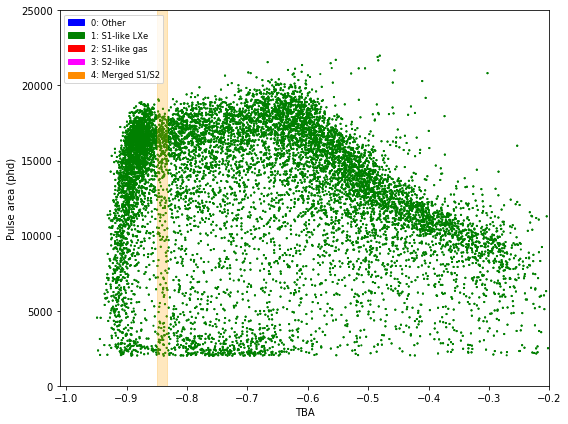

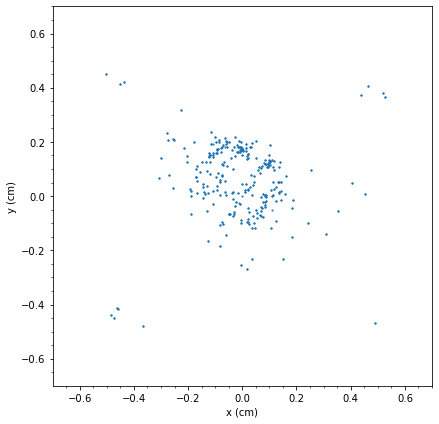

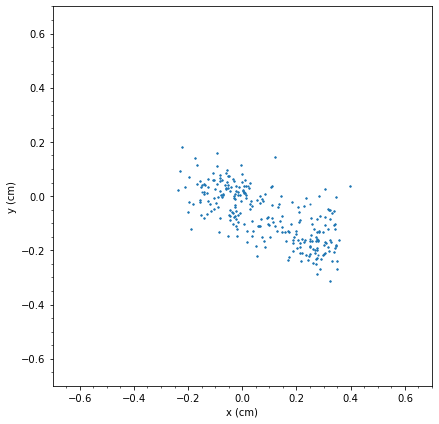

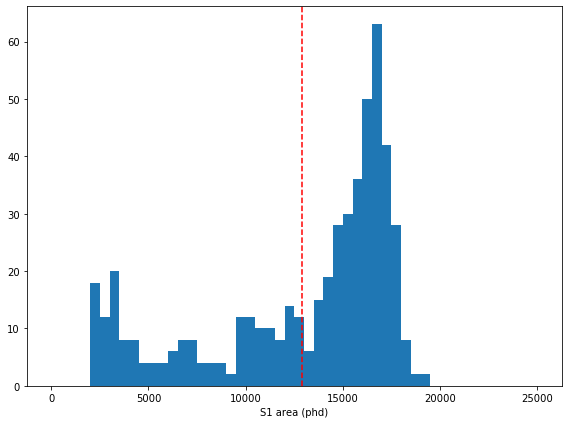

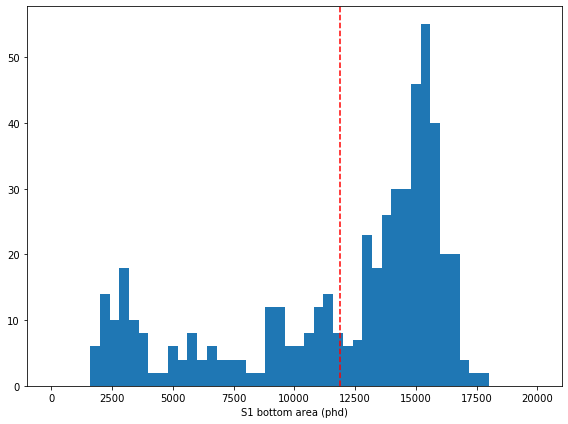

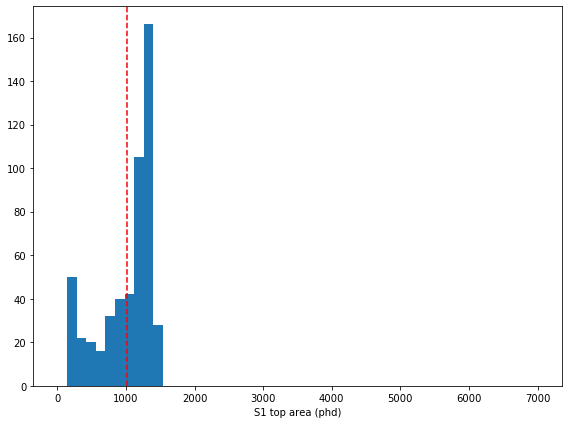

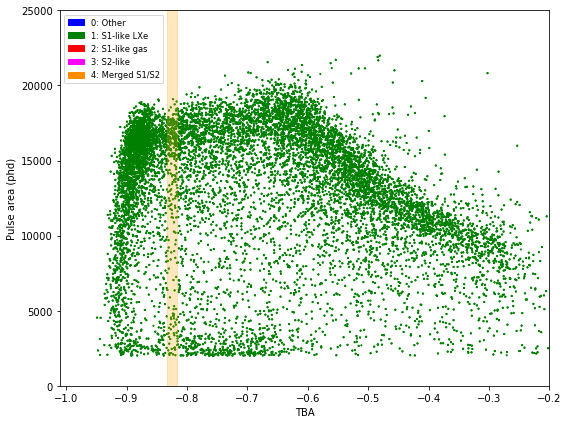

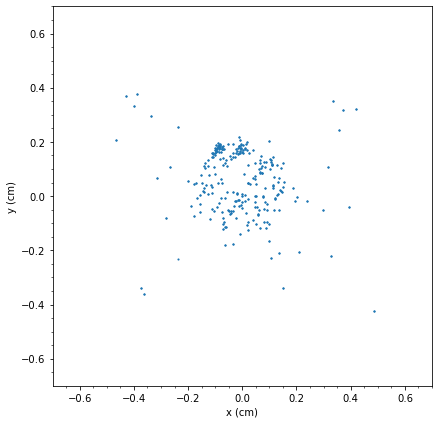

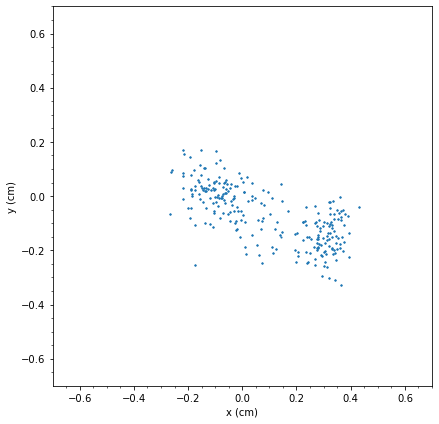

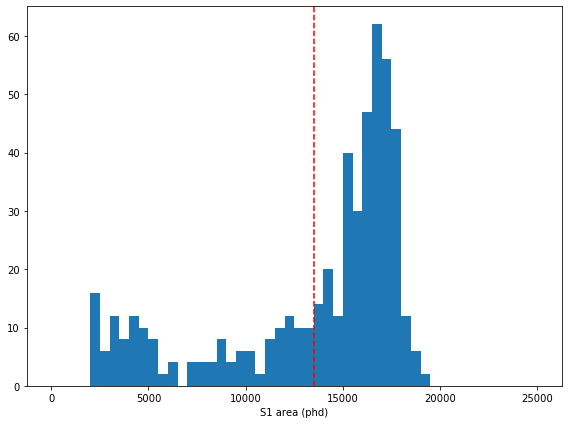

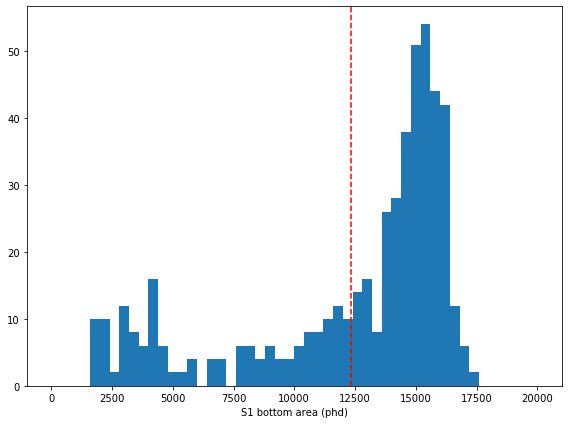

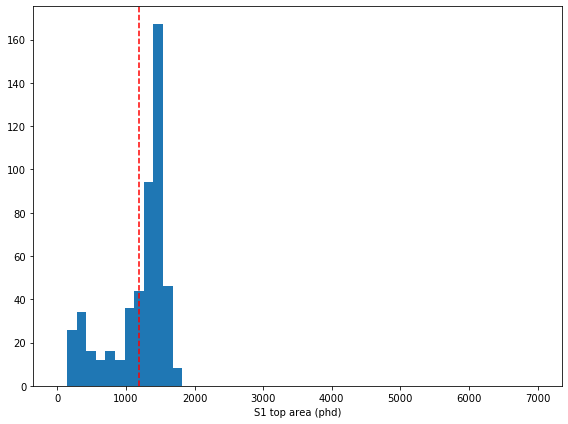

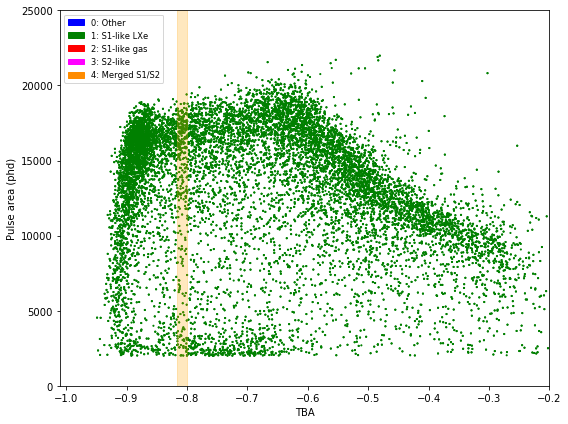

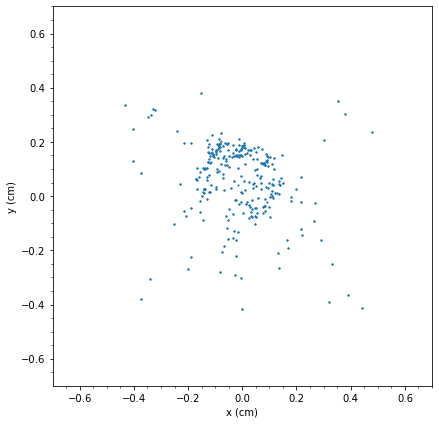

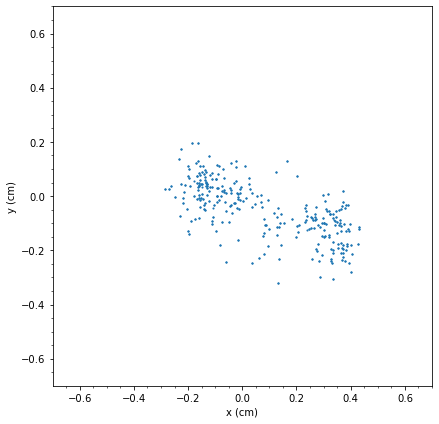

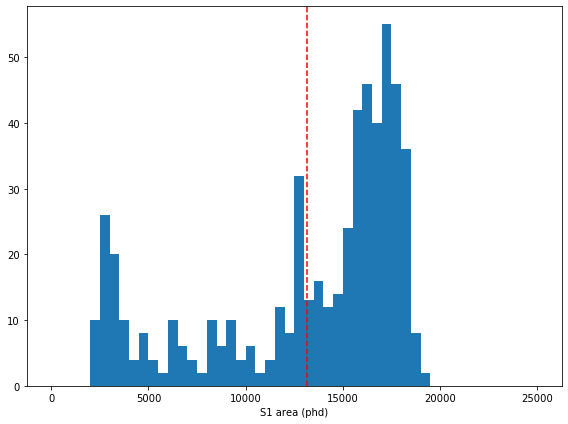

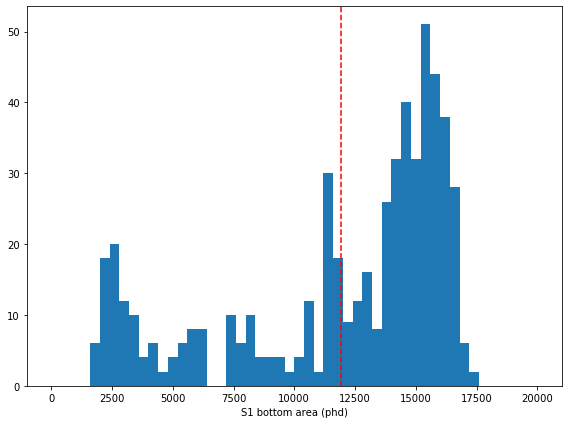

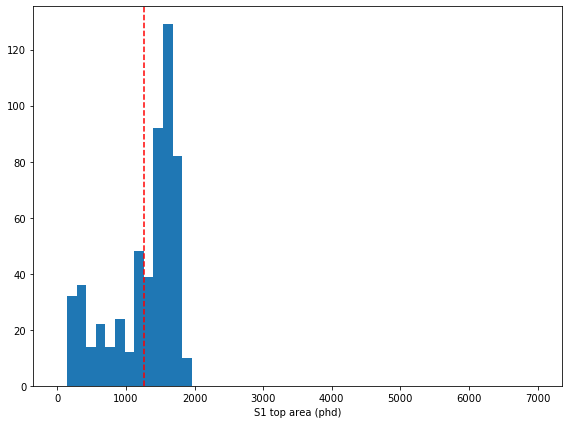

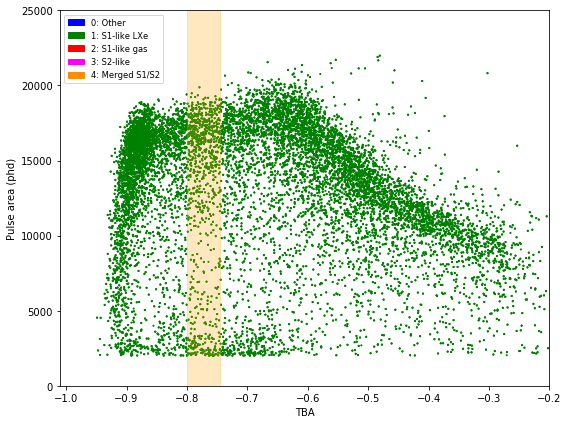

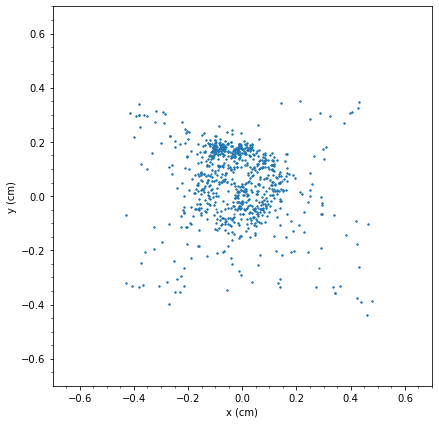

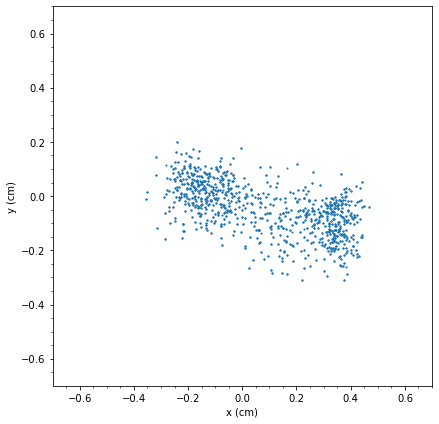

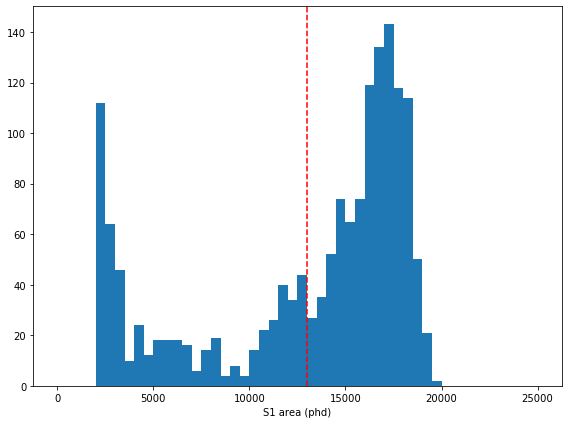

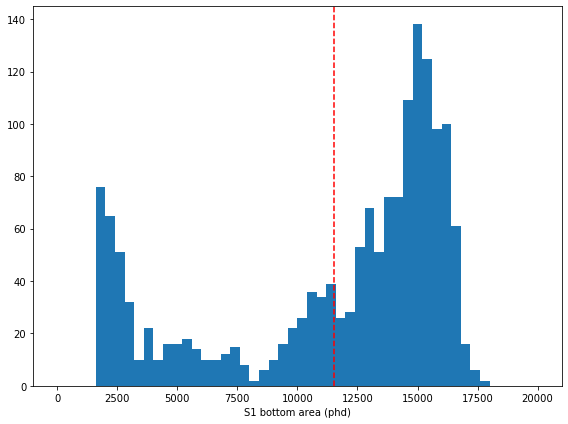

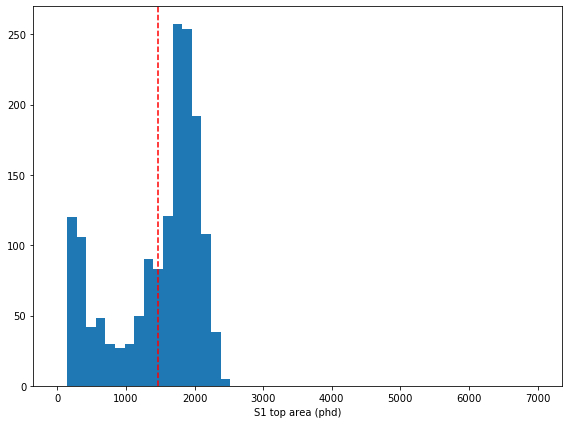

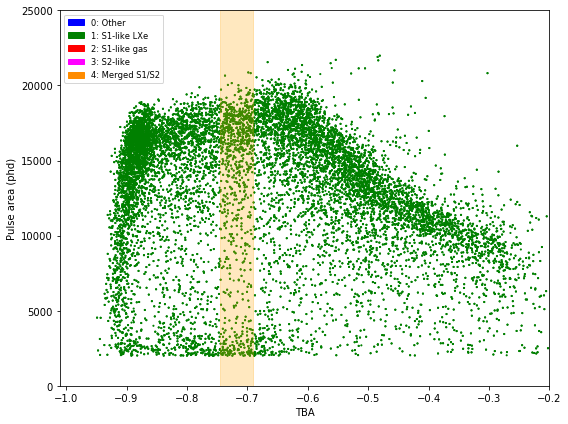

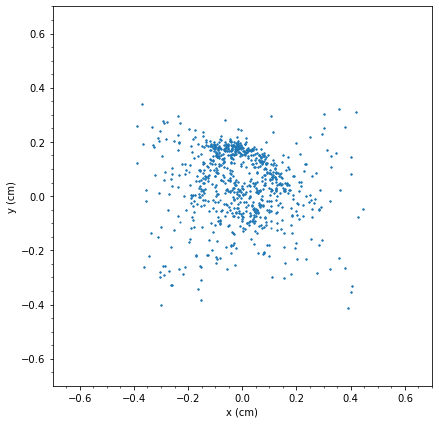

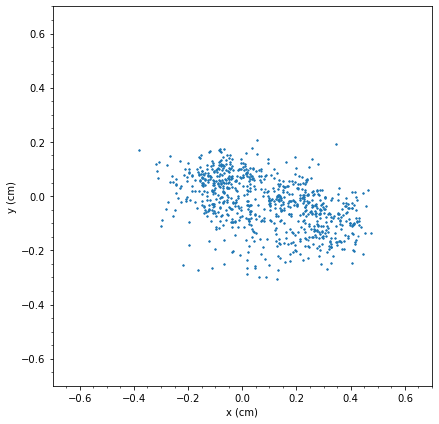

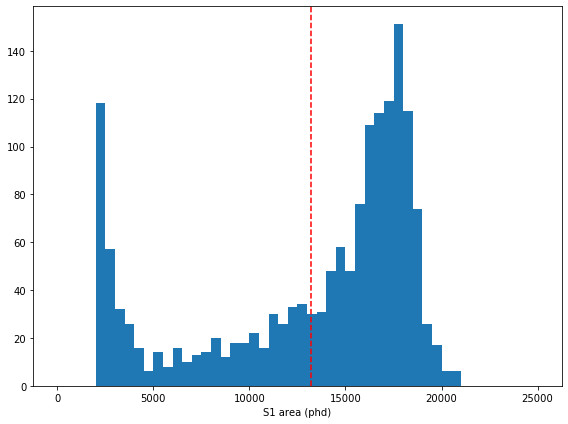

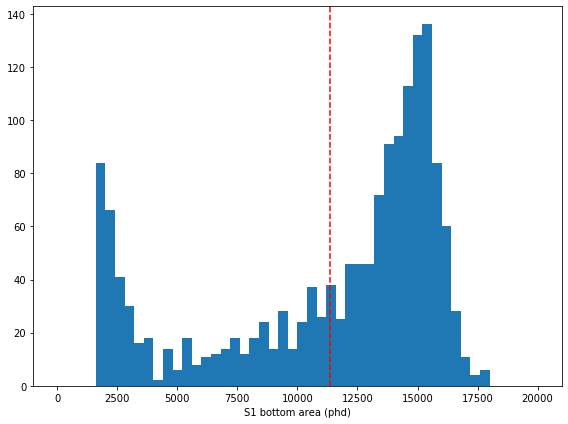

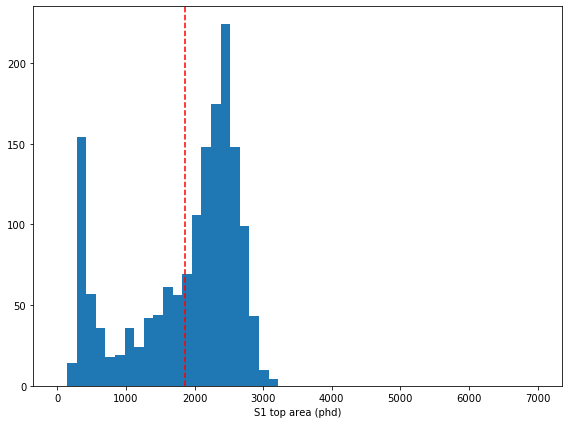

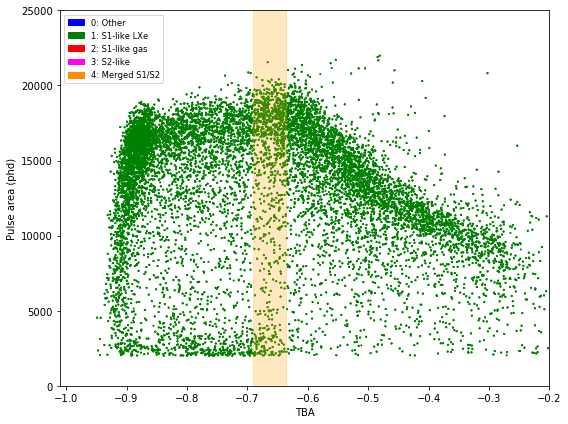

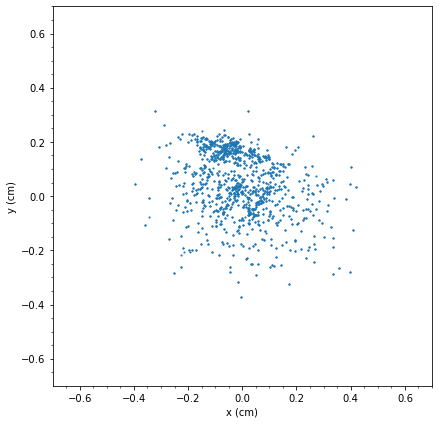

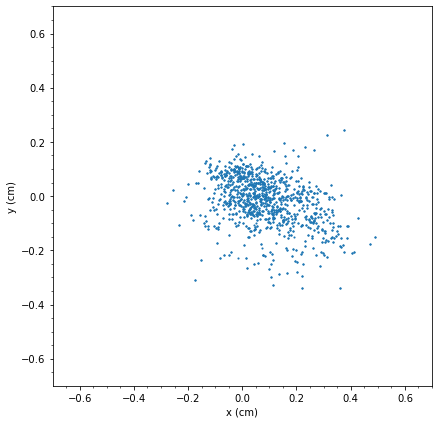

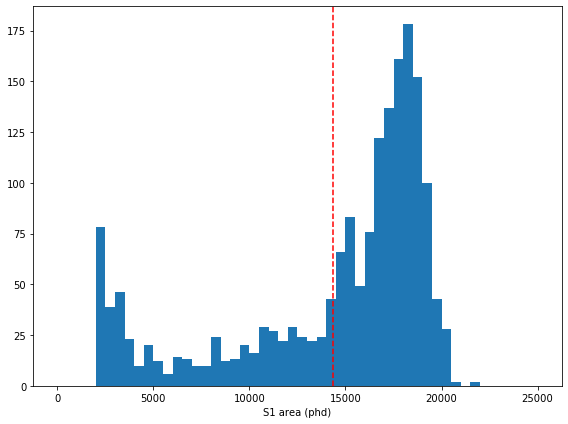

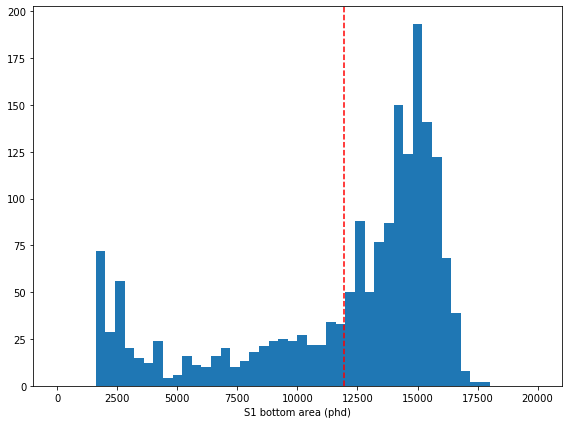

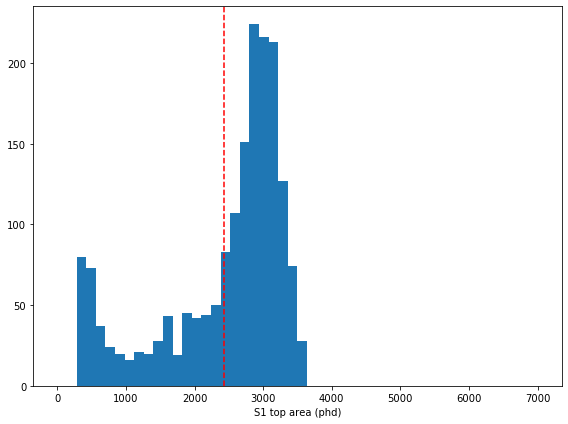

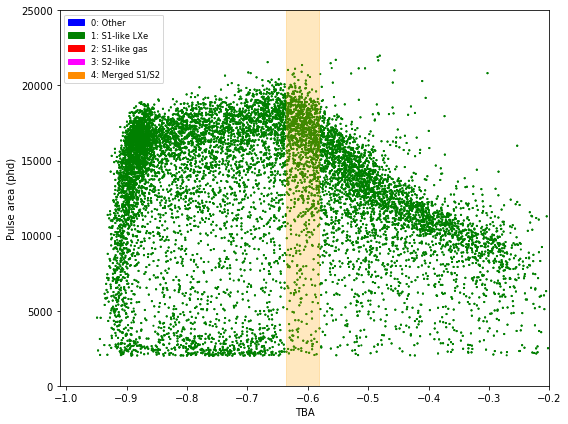

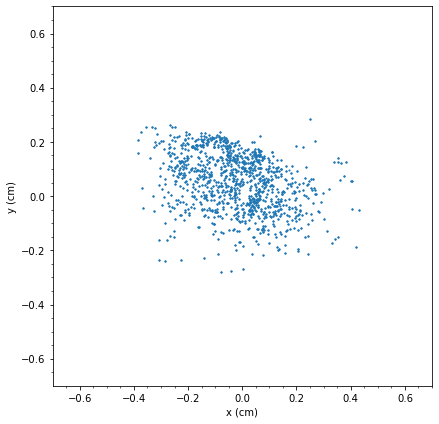

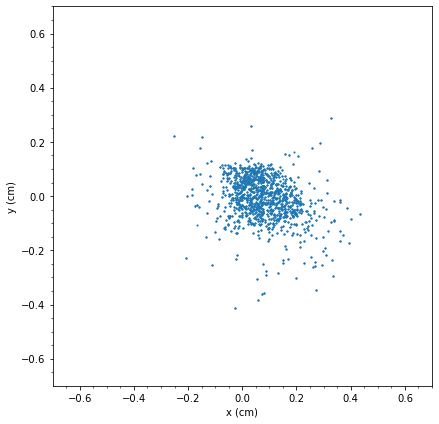

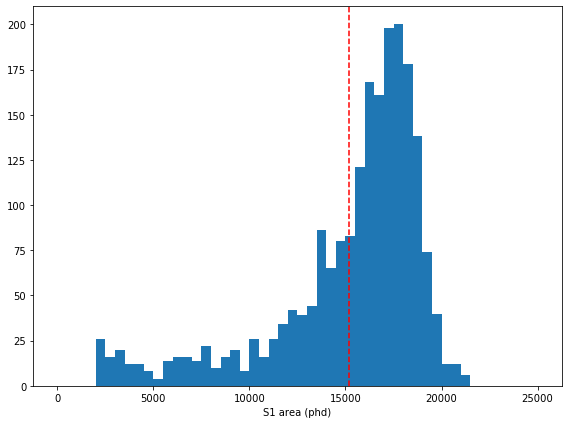

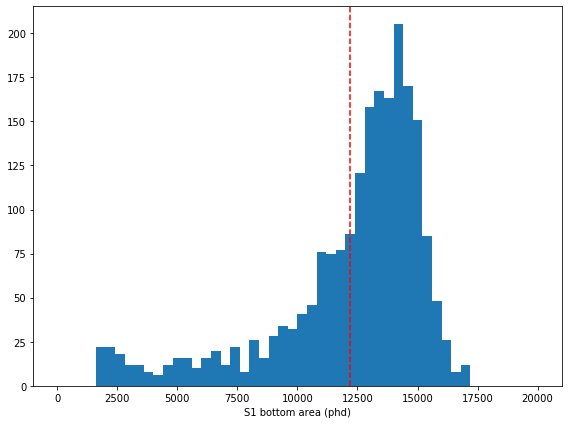

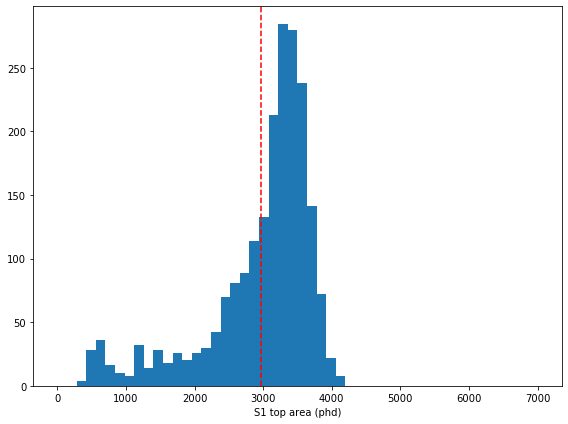

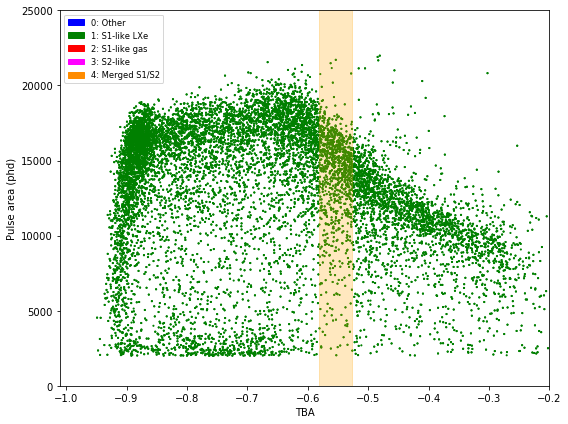

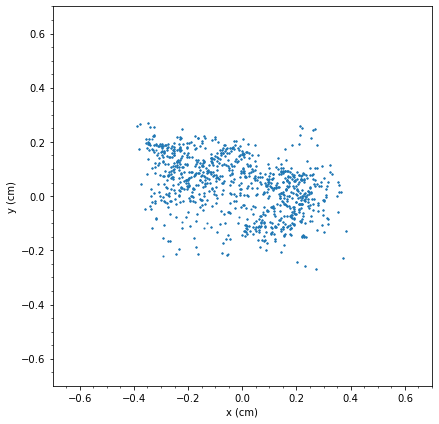

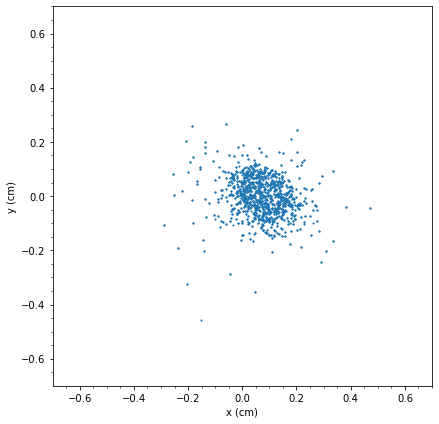

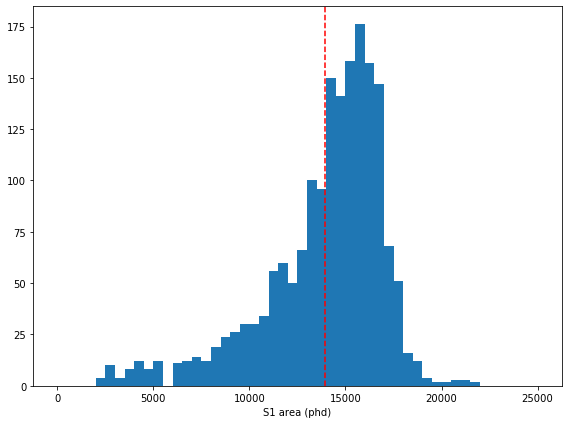

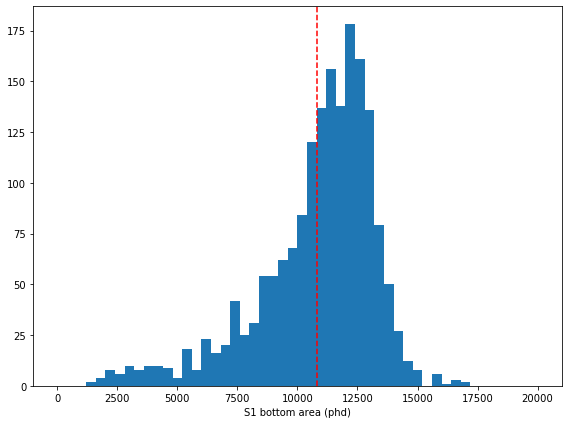

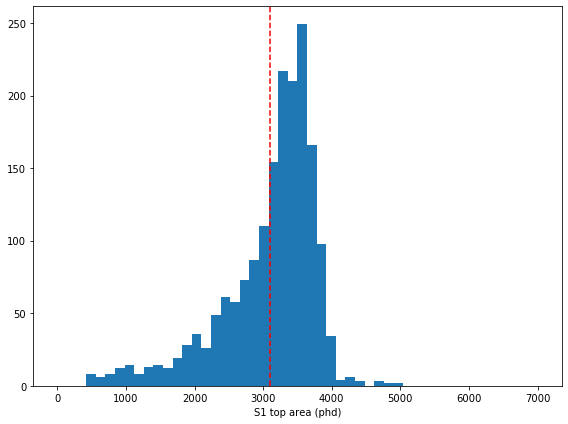

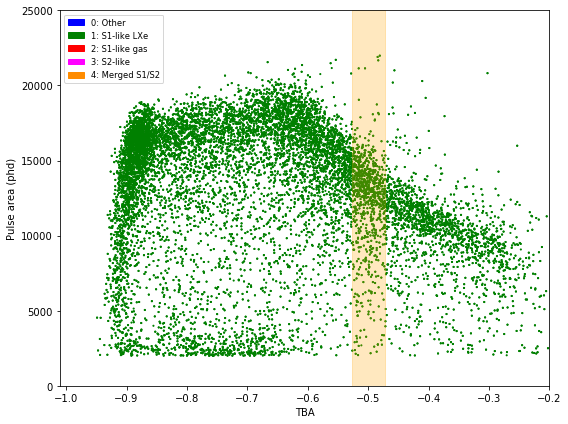

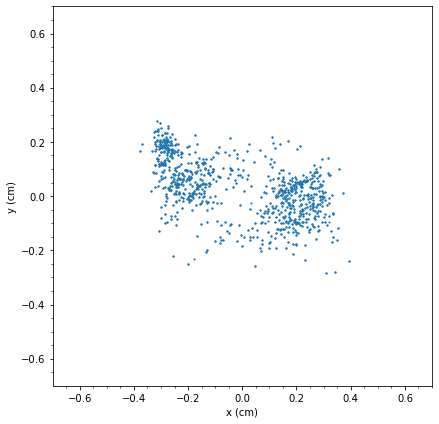

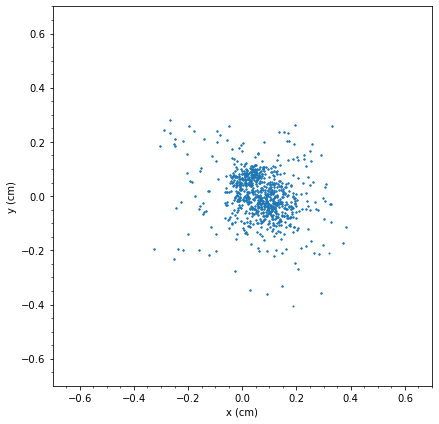

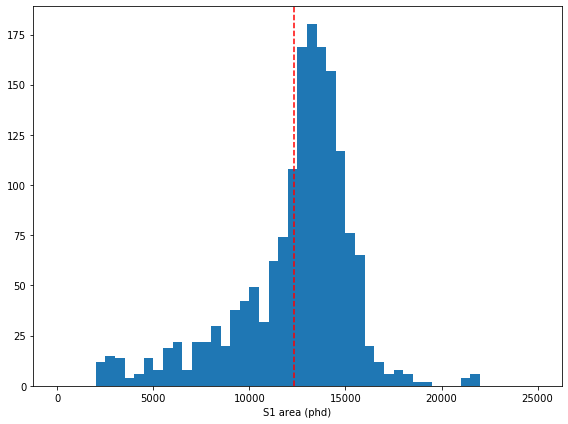

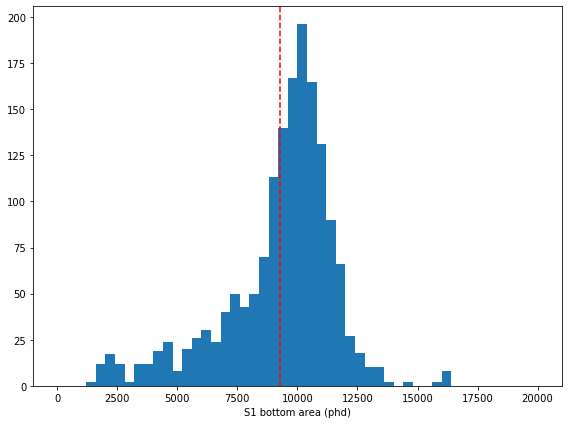

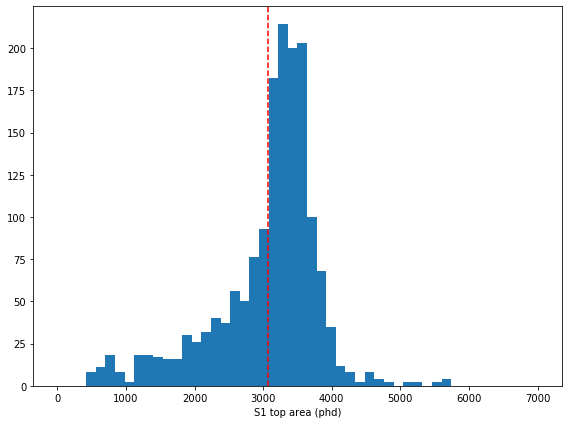

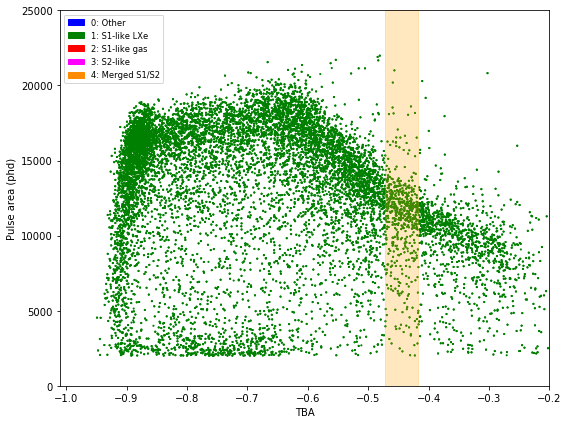

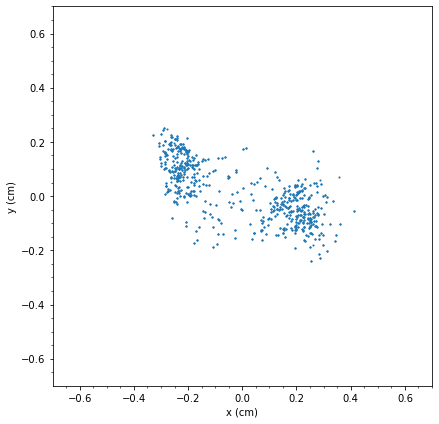

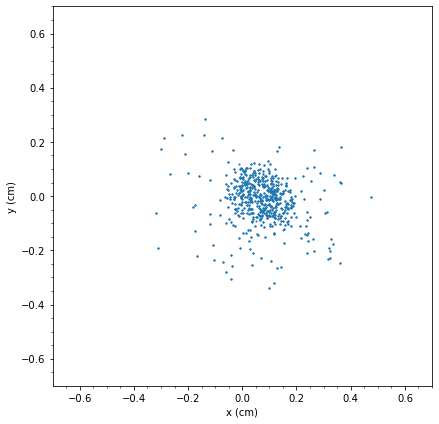

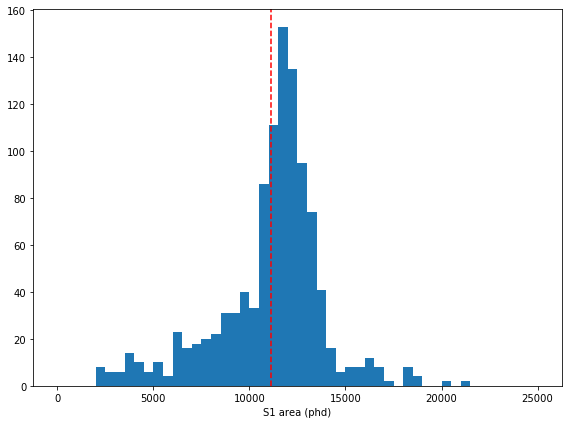

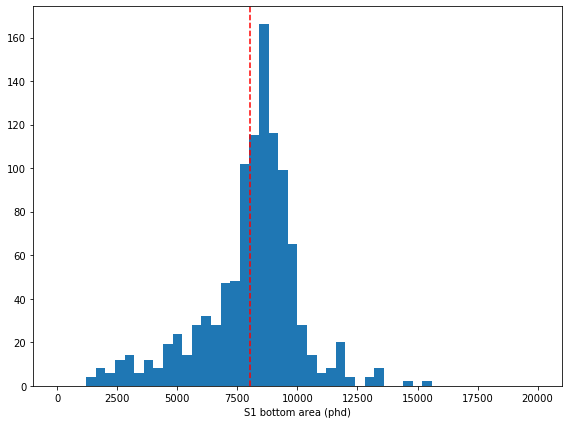

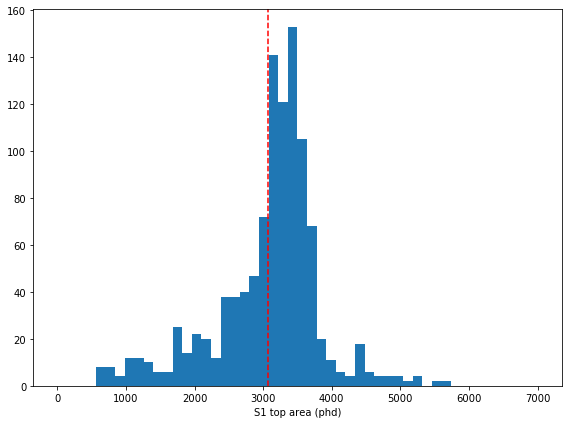

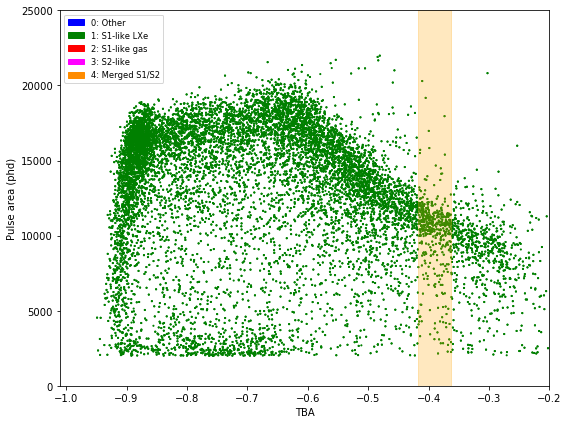

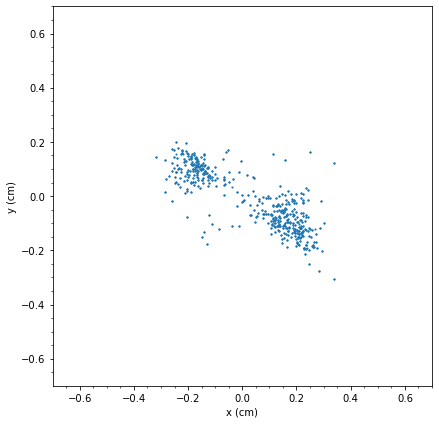

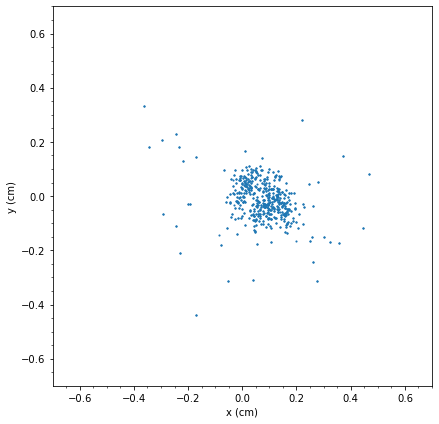

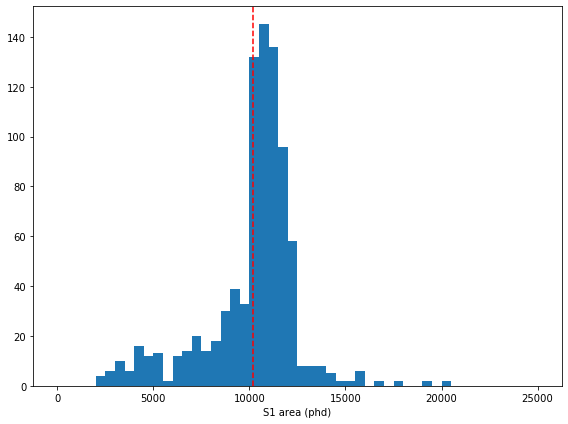

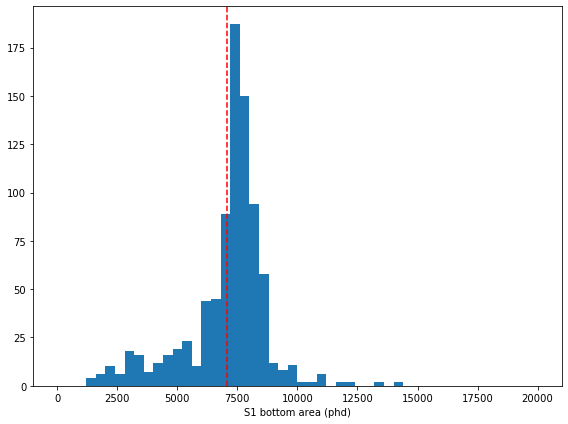

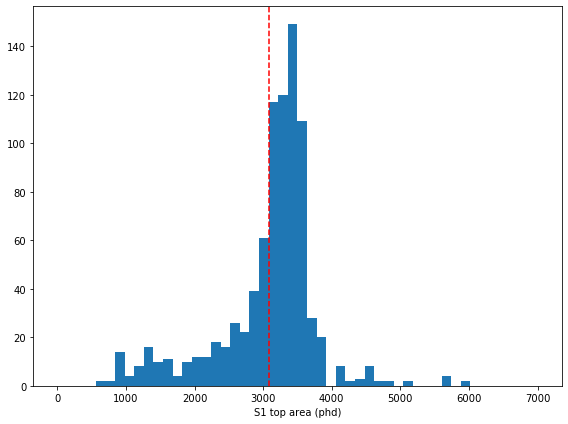

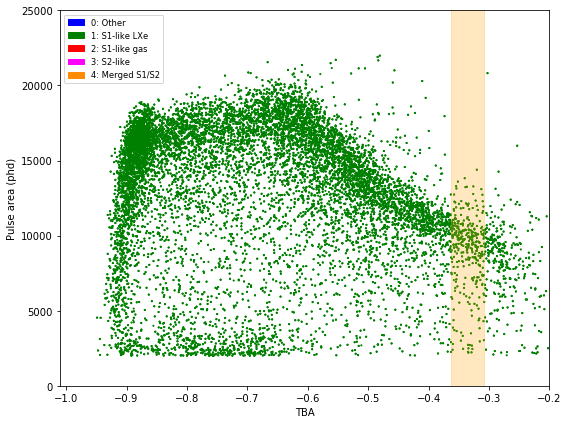

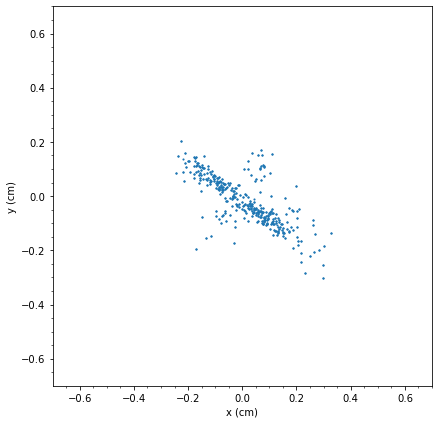

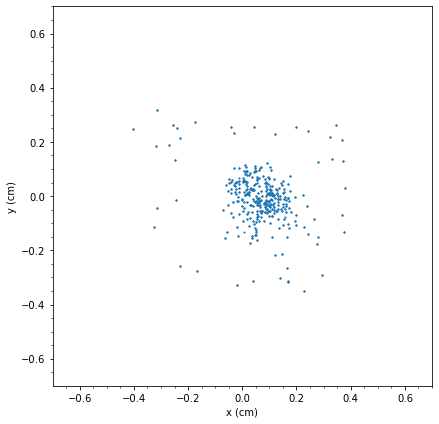

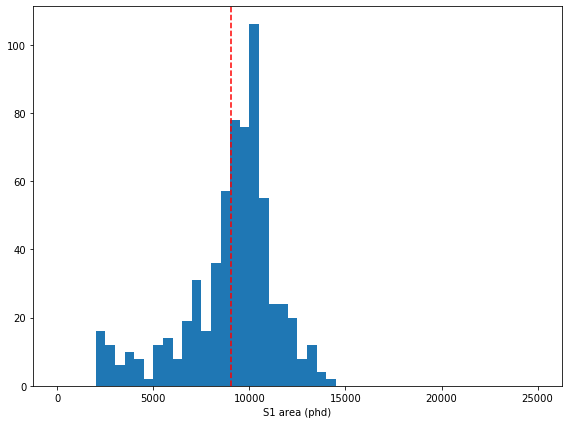

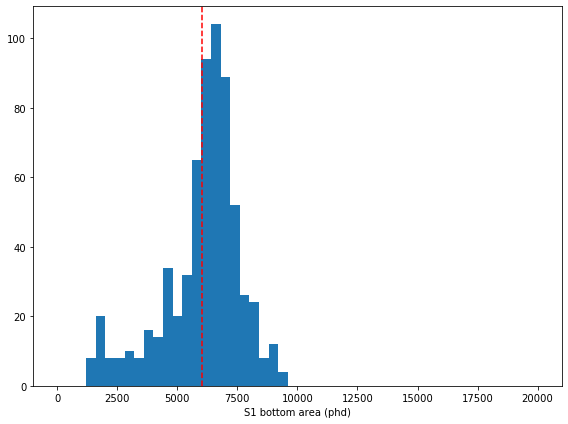

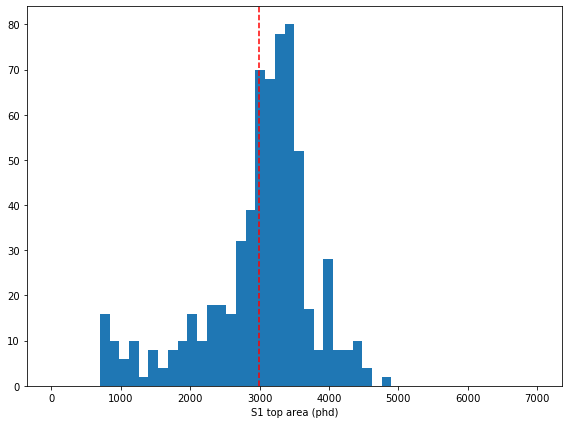

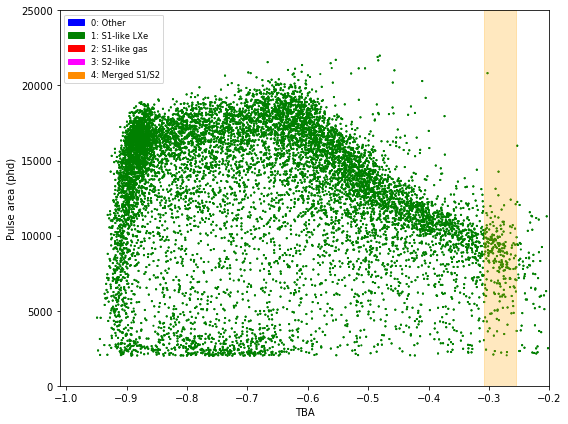

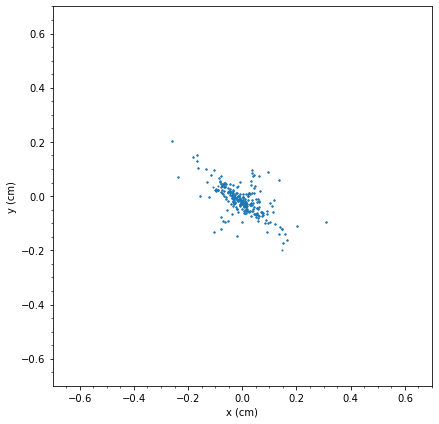

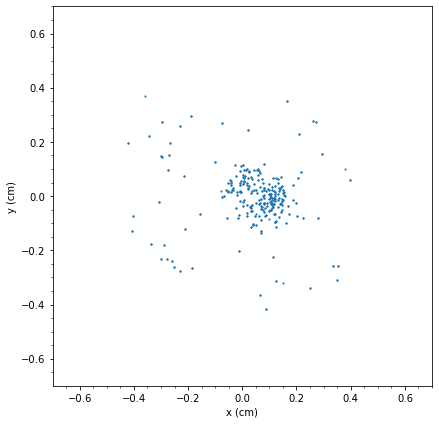

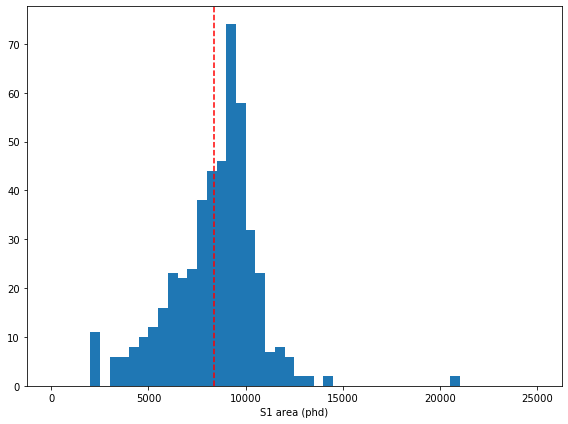

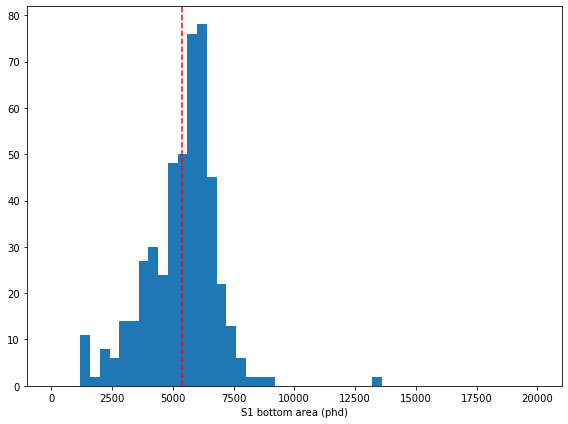

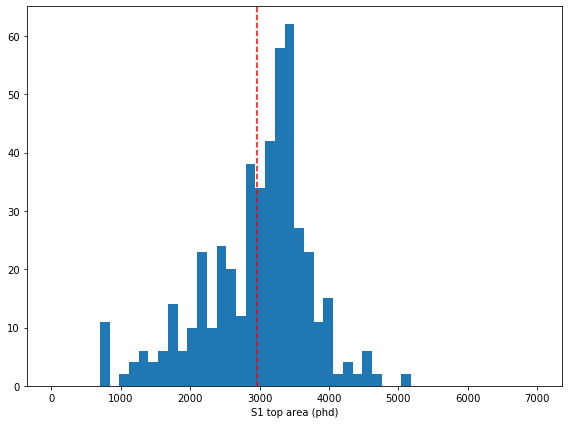

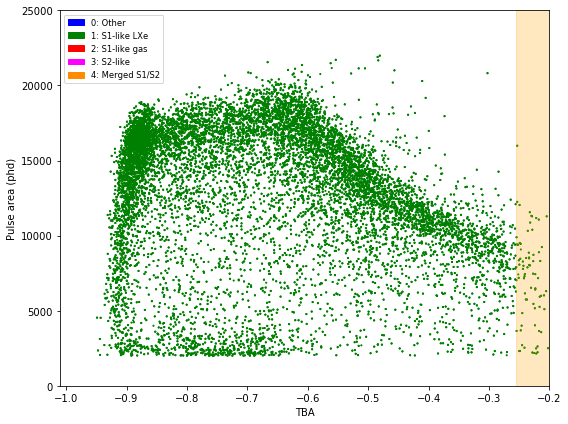

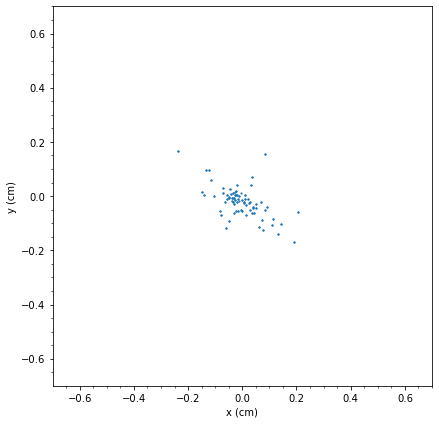

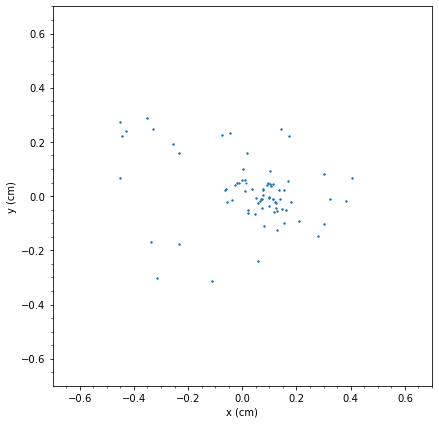

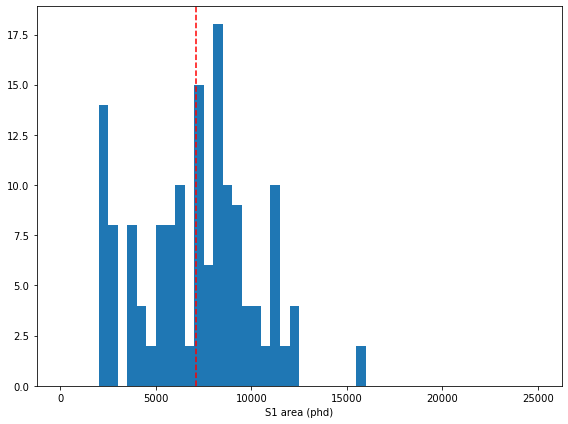

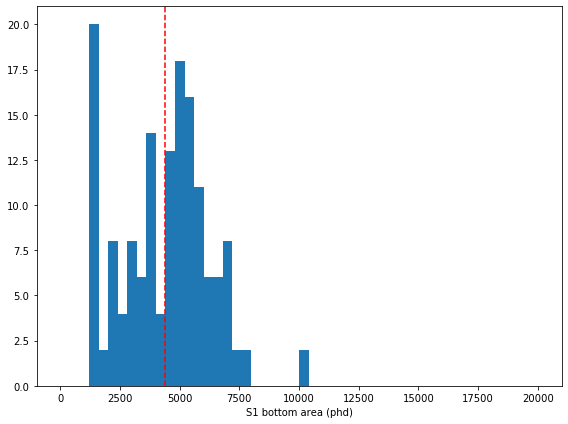

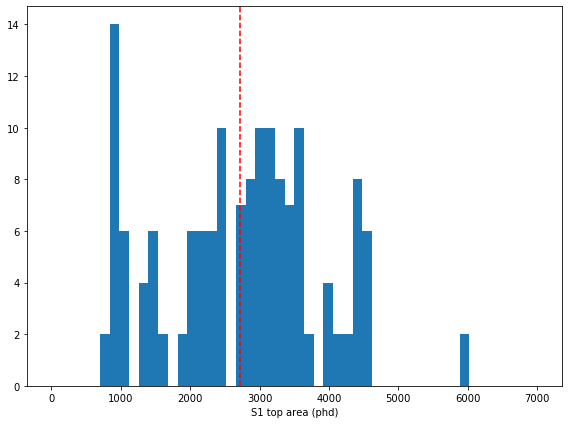

In [58]:
import os

subdir = 'TBA_Bins'

TBA_down = np.linspace(-0.95, -0.8, 10)
TBA_up = np.linspace(-0.8, -0.2, 12)
TBA_bins = np.concatenate((TBA_down, TBA_up[1:]))
save = True
show = True
if save: 
    try: 
        os.mkdir(data_dir+'/'+subdir) 
    except OSError as error: 
        pass

# Make plots for different TBA bins
for ii in range(len(TBA_bins)-1):
    TBA_low = TBA_bins[ii]
    TBA_high = TBA_bins[ii+1]
    
    TBA_cut = (cleanTBA>=TBA_low)*(cleanTBA<TBA_high)
    
    # Plot of area vs TBA w/ this TBA bin highlighted
    plt.figure()
    plt.scatter(cleanTBA, cleanArea, s=1.2, c=pulse_class_colors[cleanPulseClass])
    plt.legend(handles=pc_legend_handles)
    plt.xlim(-1.01, -0.2)
    plt.ylim(0, 25000)
    plt.xlabel("TBA")
    plt.ylabel("Pulse area (phd)")
    plt.gca().axvspan(TBA_low, TBA_high, alpha=0.25, color='orange')
        
    if save and data_dir is not None: plt.savefig(str(data_dir)+'/'+subdir+"/PulseArea_vs_TBA_"+pulse_cut_name+"_"+str(ii)+"_TBA_{0:.3}-{1:.3}".format(TBA_low, TBA_high)+".png")
    if show: plt.show()
        
    # Plot of S1 bottom array centroid for this TBA bin
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    this_bot_x = clean_center_bot_x_d[TBA_cut]
    this_bot_y = clean_center_bot_y_d[TBA_cut]
    plt.scatter(this_bot_x, this_bot_y, s = 1.2)
    plt.xlim(-0.7,0.7)
    plt.ylim(-0.7,0.7)
    plt.ylabel("y (cm)")
    plt.xlabel("x (cm)")
    plt.minorticks_on()
    ax.set_aspect('equal', adjustable='box')
    # circ = plt.Circle((0,0), radius=TPC_diameter/2, color='g', fill = False)
    # ax.add_patch(circ)
    # ax.annotate('TPC', xy =(TPC_diameter/2*np.cos(np.pi*37/180), TPC_diameter/2*np.sin(np.pi*37/180)),
    #                 xytext =(1.4, 1.2), 
    #                 arrowprops = dict(facecolor ='green',
    #                                   shrink = 0.05))
    
    if save and data_dir is not None: plt.savefig(str(data_dir)+'/'+subdir+"/S1b_centroid_"+pulse_cut_name+"_"+str(ii)+"_TBA_{0:.3}-{1:.3}".format(TBA_low, TBA_high)+".png")
    if show: plt.show()
    
    # Plot of S1 top array centroid for this TBA bin
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    this_top_x = clean_center_top_x_d[TBA_cut]
    this_top_y = clean_center_top_y_d[TBA_cut]
    plt.scatter(this_top_x, this_top_y, s = 1.2)
    plt.xlim(-0.7,0.7)
    plt.ylim(-0.7,0.7)
    plt.ylabel("y (cm)")
    plt.xlabel("x (cm)")
    plt.minorticks_on()
    ax.set_aspect('equal', adjustable='box')
    # circ = plt.Circle((0,0), radius=TPC_diameter/2, color='g', fill = False)
    # ax.add_patch(circ)
    # ax.annotate('TPC', xy =(TPC_diameter/2*np.cos(np.pi*37/180), TPC_diameter/2*np.sin(np.pi*37/180)),
    #                 xytext =(1.4, 1.2), 
    #                 arrowprops = dict(facecolor ='green',
    #                                   shrink = 0.05))
    
    if save and data_dir is not None: plt.savefig(str(data_dir)+'/'+subdir+"/S1t_centroid_"+pulse_cut_name+"_"+str(ii)+"_TBA_{0:.3}-{1:.3}".format(TBA_low, TBA_high)+".png")
    if show: plt.show()
        
    # Simple hist of S1 area for this TBA bin
    this_area = cleanArea[TBA_cut]
    basicHist(this_area, bins=50, hRange=[0, 25000], xlabel='S1 area (phd)', mean=True, name="S1_"+pulse_cut_name+"_"+str(ii)+"_TBA_{0:.3}-{1:.3}".format(TBA_low, TBA_high), save=save, data_dir=str(data_dir)+'/'+subdir+'/')
    
    # Simple hist of S1b area for this TBA bin
    this_area_b = cleanAreaBottom[TBA_cut]
    basicHist(this_area_b, bins=50, hRange=[0, 20000], xlabel='S1 bottom area (phd)', mean=True, name="S1_bottom_"+pulse_cut_name+"_"+str(ii)+"_TBA_{0:.3}-{1:.3}".format(TBA_low, TBA_high), save=save, data_dir=str(data_dir)+'/'+subdir+'/')
    
    # Simple hist of S1t area for this TBA bin
    this_area_t = cleanAreaTop[TBA_cut]
    basicHist(this_area_t, bins=50, hRange=[0, 7000], xlabel='S1 top area (phd)', mean=True, name="S1_top_"+pulse_cut_name+"_"+str(ii)+"_TBA_{0:.3}-{1:.3}".format(TBA_low, TBA_high), save=save, data_dir=str(data_dir)+'/'+subdir+'/')